In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras import backend

In [39]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Rice Leaf Disease Classification\mendeley dataset\Rice Leaf Disease Images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [4]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


186

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 2 3 0 2 0 2 3 0 2 3 1 1 2 2 1 0 2 0 0 2 1 3 3 3 0 1 0 0 3 2]


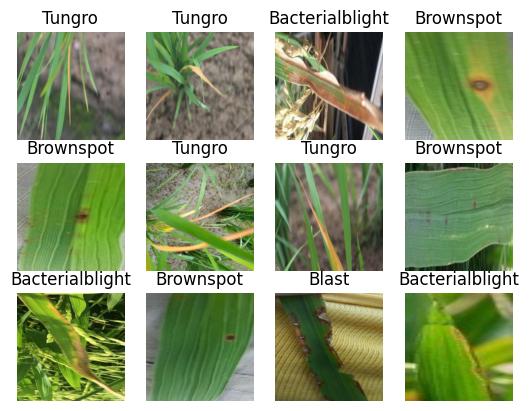

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

***Function to Split Dataset***

Dataset should be bifurcated into 3 subsets, namely:


Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model


In [7]:
len(dataset)

186

In [8]:
train_size=0.8
len(dataset)*train_size


148.8

In [9]:
train_ds = dataset.take(148)
len(train_ds)

148

In [10]:
test_ds=dataset.skip(148)
len(test_ds)

38

In [11]:
val_size= 0.1
len(dataset)*val_size

18.6

In [12]:
val_ds=test_ds.take(18)
len(val_ds)

18

In [13]:
test_ds=test_ds.skip(18)
len(test_ds)

20

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

148
18
20


Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating a Layer for Resizing and Normalization

In [16]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1./255),
])

***Data Augmentation***

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [17]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
148/148 [==============================] - 276s 2s/step - loss: 1.0849 - accuracy: 0.5165 - val_loss: 0.8727 - val_accuracy: 0.6441
Epoch 2/20
148/148 [==============================] - 227s 2s/step - loss: 0.7900 - accuracy: 0.6966 - val_loss: 0.7414 - val_accuracy: 0.7222
Epoch 3/20
148/148 [==============================] - 221s 1s/step - loss: 0.5793 - accuracy: 0.7833 - val_loss: 0.5028 - val_accuracy: 0.8281
Epoch 4/20
148/148 [==============================] - 232s 2s/step - loss: 0.4119 - accuracy: 0.8482 - val_loss: 0.3001 - val_accuracy: 0.8767
Epoch 5/20
148/148 [==============================] - 227s 2s/step - loss: 0.3455 - accuracy: 0.8690 - val_loss: 0.2762 - val_accuracy: 0.8976
Epoch 6/20
148/148 [==============================] - 220s 1s/step - loss: 0.2647 - accuracy: 0.9008 - val_loss: 0.6685 - val_accuracy: 0.7361
Epoch 7/20
148/148 [==============================] - 221s 1s/step - loss: 0.2331 - accuracy: 0.9190 - val_loss: 0.2776 - val_accuracy: 0.9010

In [22]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 28s 358ms/step - loss: 0.0212 - accuracy: 0.9937


In [23]:
scores

[0.021156376227736473, 0.9937499761581421]

In [27]:
history


In [28]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 148}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:
len(history.history['loss'])

20

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0848997831344604,
 0.7900336384773254,
 0.5793164968490601,
 0.4119066894054413,
 0.3454776406288147]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

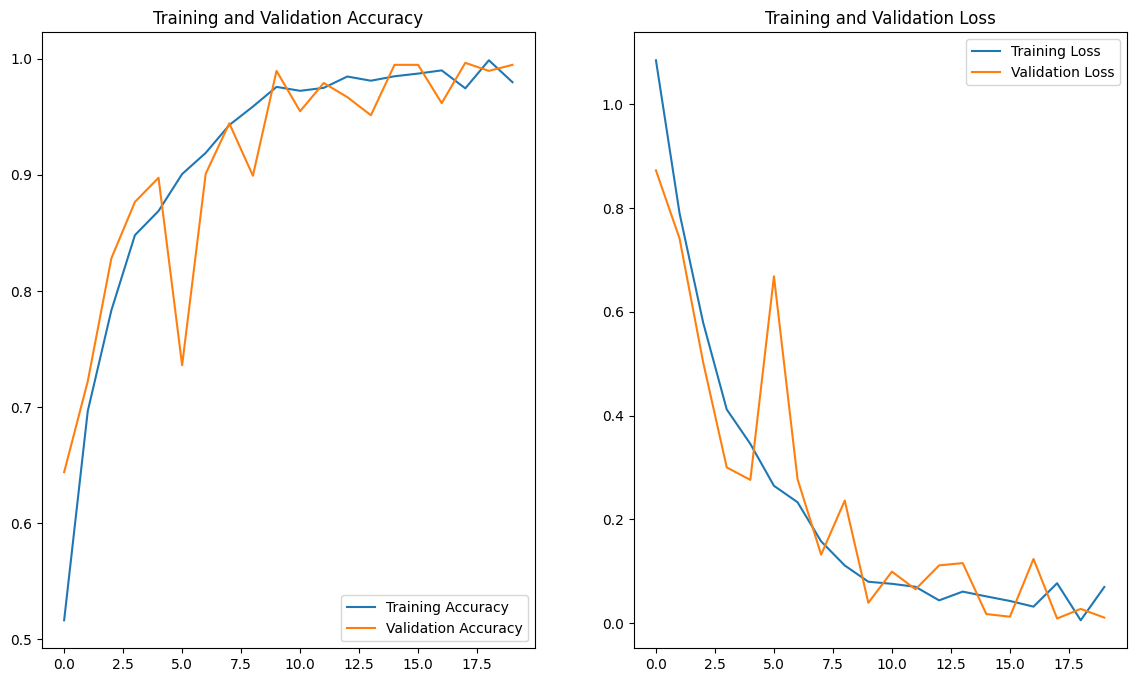

In [43]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tungro
1/1 [==============================] - 0s 356ms/step
predicted label: Tungro


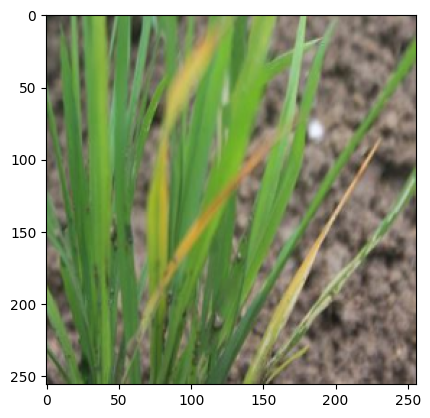

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


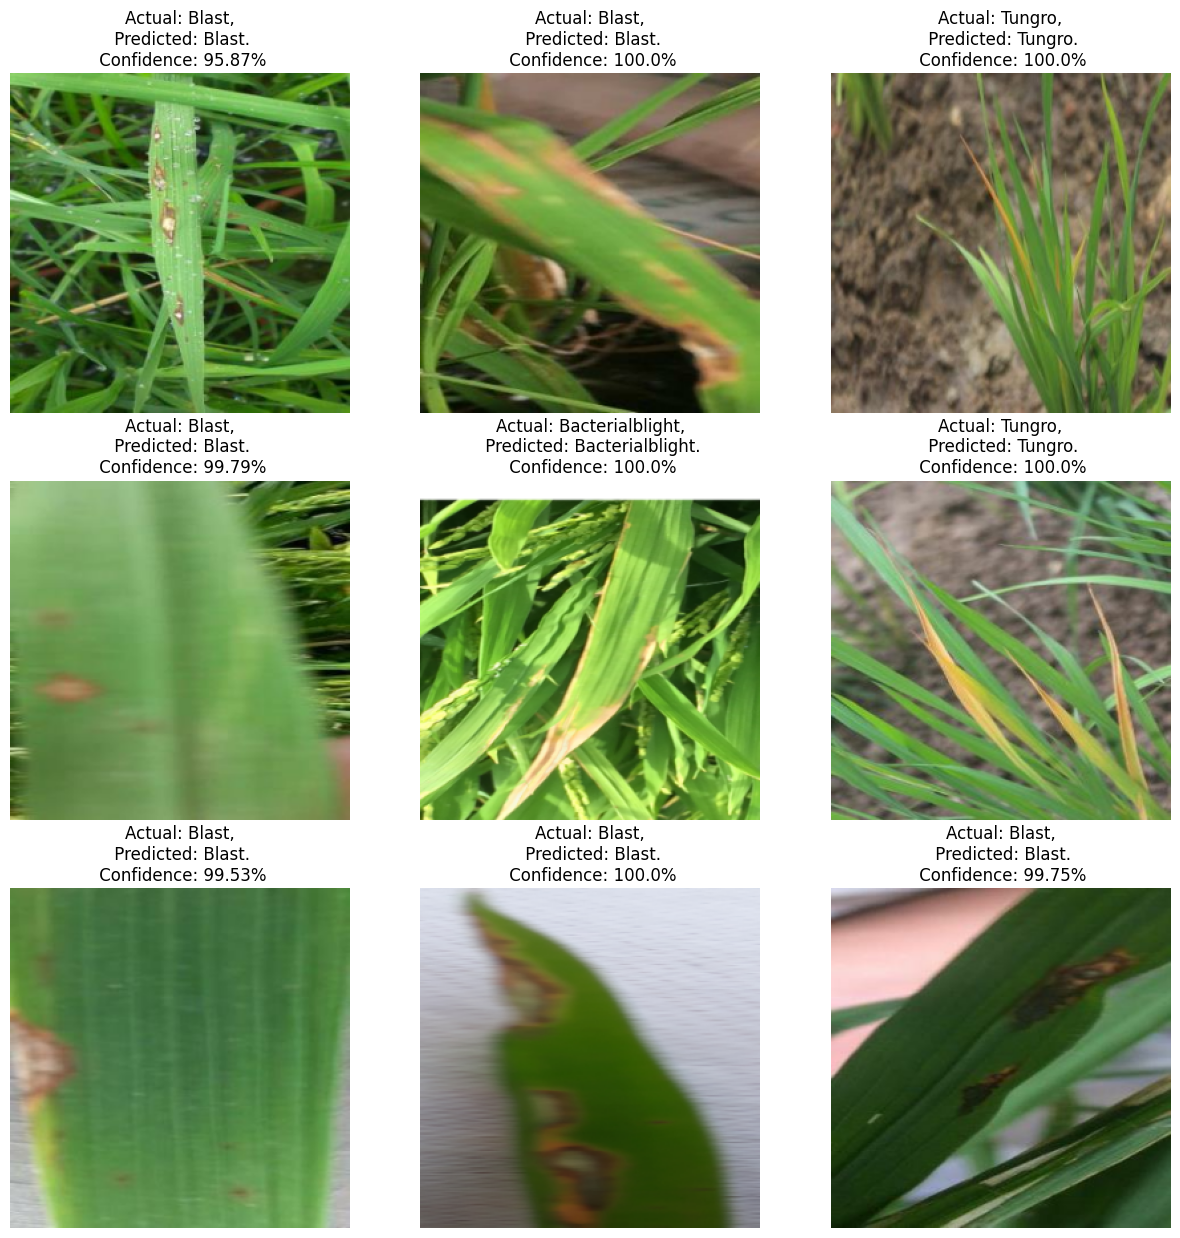

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
import os

directory = '../models'
if not os.path.exists(directory):
    os.makedirs(directory)

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [54]:
model.save("../riceleafdisease.h5")

20/20 [==============================] - 8s 345ms/step


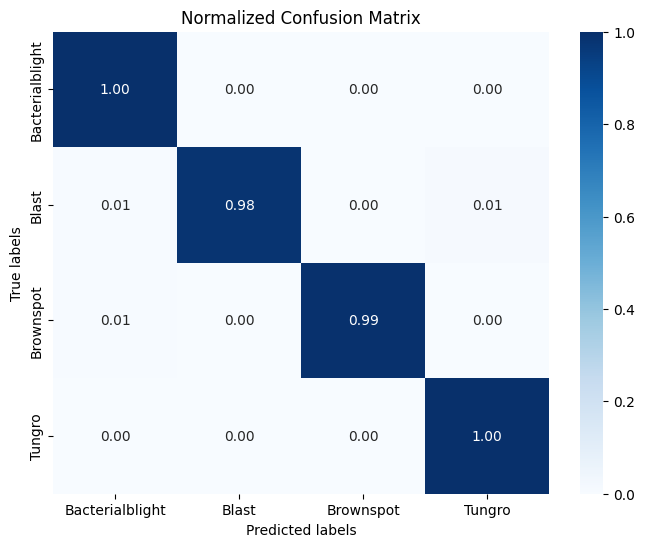

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)

# Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()


In [56]:
from sklearn.metrics import classification_report

# Generate classification report
target_names = class_names  # Use the class names as target names
report = classification_report(test_labels, predicted_labels, target_names=target_names)

# Print the classification report
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.99      1.00      0.99       165
          Blast       1.00      0.98      0.99       167
      Brownspot       1.00      0.99      1.00       171
         Tungro       0.99      1.00      0.99       137

       accuracy                           0.99       640
      macro avg       0.99      0.99      0.99       640
   weighted avg       0.99      0.99      0.99       640

